# Поиск выбросов во временных рядах и числовых данных.

Данная функция позволяет при помощи методов машинного обучения (Robust covariance, One-ClassSVM, Isolation Forest, Local Outlier Factor) и классических статистических методов (MAD, Box_plot, 3Std Dev), детектировать экстремальные значения во временном ряду (arr). Перед использованием, желательно очистить ряд от тренда и сезонности. 
Функция работает в двух режимах:

1) type='analysis', отображает графически работу всех алгоритмов, для выбора наиболее подходящего. 
2) type='use', позволяет выбрать конкретный метод и на выходе получить переменную, очищенную от выбросов (необходимо при этом заполнить параметр method, с названием алгоритма).

In [233]:
df = pd.read_csv('sales-of-shampoo.csv',sep=',',parse_dates=[0])

In [234]:
def detected_outliers (arr,type,method=0):
    
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import IsolationForest
    from sklearn.covariance import EllipticEnvelope
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.svm import OneClassSVM
    
    outliers_fraction = 0.07
    data = pd.DataFrame((arr.astype(float)-np.mean(arr.astype(float)))/np.std(arr.astype(float)))
    anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-ClassSVM", OneClassSVM(nu=outliers_fraction, kernel="rbf",gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction)),
    ("Local Outlier Factor", LocalOutlierFactor(contamination=outliers_fraction)),
    ('Stat_box_plot',((np.quantile(arr, 0.75)-np.quantile(arr, 0.25))*1.5)),
    ('Stat_mad',(np.median(np.abs(arr - np.median(arr)))*5)),
    ('Stat_3std',(np.mean(np.abs(arr - np.mean(arr)))*3)),
    ('Stat_99per',np.percentile(arr, 99))]
   
    data_f=pd.DataFrame({'variable':pd.Series(arr)})
    for name, algorithm in anomaly_algorithms:
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(data)
        elif name=='Stat_box_plot':
            y_pred=[]
            for i in arr:
                if i>(np.quantile(arr, 0.75)+algorithm) or i<(np.quantile(arr, 0.25)-algorithm):s=-1
                else:s=1
                y_pred.append(s)
        elif name=='Stat_mad':
            y_pred=[]
            for i in arr:
                if i > np.median(arr)+algorithm or i<np.median(arr)-algorithm:s=-1 
                else:s=1
                y_pred.append(s)
        elif name=='Stat_3std':
            y_pred=[]
            for i in arr:
                if i > np.mean(arr)+algorithm or i<np.mean(arr)-algorithm:s=-1 
                else:s=1
                y_pred.append(s)
        elif name=='Stat_99per':
            y_pred=[]
            for i in arr:
                if i > algorithm:s=-1 
                else:s=1
                y_pred.append(s)
        else:
            y_pred = algorithm.fit(data).predict(data) 
        
        data_f['outliers'] = pd.DataFrame(y_pred)
        data_f[name] =np.where(data_f['outliers'] == -1,data_f['variable'],np.NaN)
    if type=='analysis':     
        plt.figure(figsize=(15, 12))
        for i, col in enumerate(data_f.columns[2:10]):
            plt.style.use('seaborn')
            plt.subplot(4, 2, i+1 )
            plt.plot(data_f.index, data_f['variable'], color='teal', label = 'Normal')
            plt.scatter(data_f.index,data_f[col], color='red', label = 'Anomaly')
            plt.legend()
            plt.title('Method %s' % col)
            plt.tight_layout()
        return
    elif type=='use':
        df_itog=pd.DataFrame({method:np.where(data_f[method].notnull(),np.NaN,data_f['variable'])})
    return df_itog

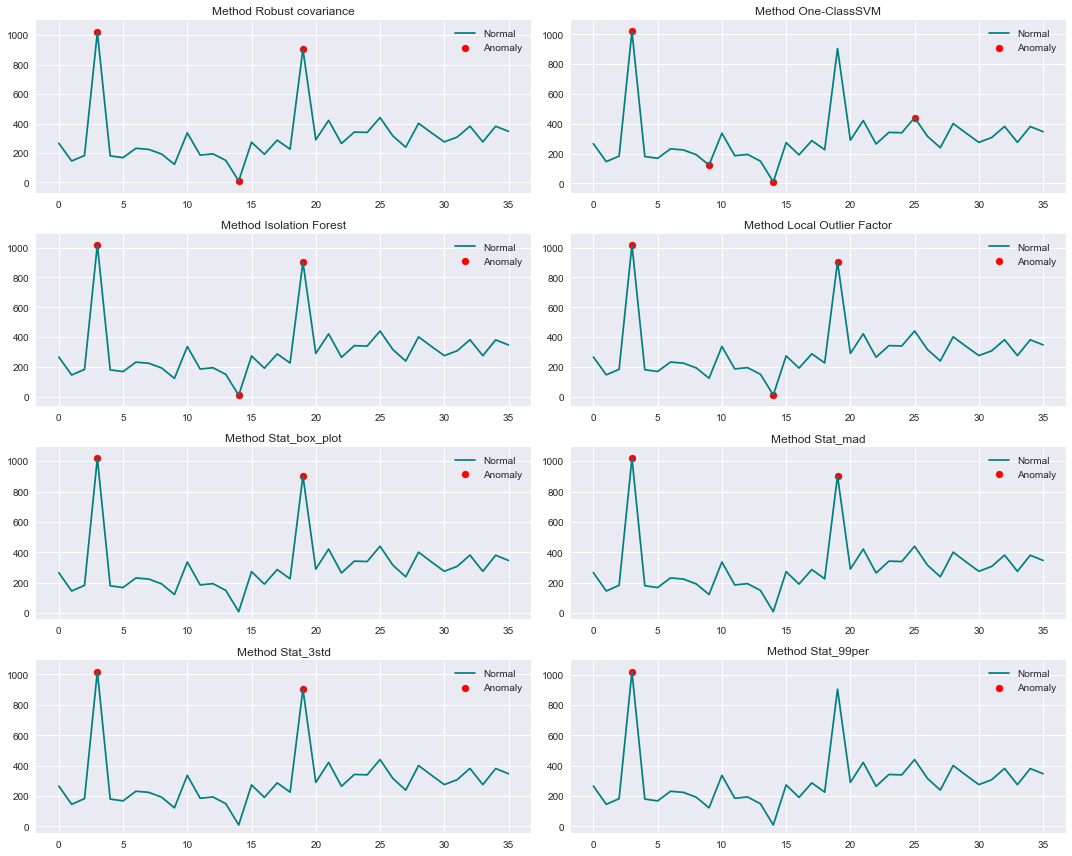

In [235]:
detected_outliers(df['Sales of shampoo over a three year period'],type='analysis')